# Proyecto de predicciones para CS2

Importamos las librerías que utilizaremos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Limpieza de datos

Cargamos los datos extraidos previamente con web scraping y la clase ``HltvScraper``.

In [2]:
data = "WebScraping/Data/"

df_matches = pd.read_csv(data + "matches_played_by_team.csv")
df_players = pd.read_csv(data + "players_stats.csv")
df_teams   = pd.read_csv(data + "teams_stats_by_map.csv")
df_pistols = pd.read_csv(data + "pistols.csv")
df_ftu     = pd.read_csv(data + "ftu.csv")

Definimos la siguiente función que nos ayudará a limpiar los datos.

In [3]:
def dividir_columna(df: pd.DataFrame, column: str, sep: str, new_names: list) -> pd.DataFrame:
    position = df.columns.get_loc(column)
    columns_created = df.pop(column).str.split(sep, expand=True)
    columns_created.columns = new_names

    for i, col in enumerate(columns_created.columns):
        df.insert(position + i, col, columns_created[col])

    return df

## Limpieza de ``df_matches``

In [4]:
df_matches.head()

,Date,Event,Opponent,Map,Result,W/L,Group,Team
0,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Ancient,13 - 2,W,europa_1,Natus Vincere
1,19/11/24,Perfect World Shanghai Major 2024 Europe RMR A,SAW,Nuke,13 - 10,W,europa_1,Natus Vincere
2,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Inferno,7 - 13,L,europa_1,Natus Vincere
3,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Dust2,8 - 13,L,europa_1,Natus Vincere
4,18/11/24,Perfect World Shanghai Major 2024 Europe RMR A,MOUZ,Mirage,13 - 4,W,europa_1,Natus Vincere


In [5]:
df_matches.dtypes

Date        object
Event       object
Opponent    object
Map         object
Result      object
W/L         object
Group       object
Team        object
dtype: object

In [6]:
df_matches = dividir_columna(df_matches, "Result", " - ", ["Rounds won", "Rounds lost"])



columns_to_int = ["Rounds won", "Rounds lost"]
columns_to_category = ["Map", "W/L", "Group", "Team"]

for col in columns_to_int:
    df_matches[col] = df_matches[col].astype(int)

for col in columns_to_category:
    df_matches[col] = df_matches[col].astype("category")

df_matches["Date"] = df_matches["Date"].astype("datetime64[ns]")

In [7]:
df_matches = df_matches.drop(["Event", "Group"], axis=1)
col = df_matches.pop("Team")
df_matches.insert(1, "Team", col)
df_matches

,Date,Team,Opponent,Map,Rounds won,Rounds lost,W/L
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W
...,...,...,...,...,...,...,...
11455,2024-08-28,DRILLAS,Al-Ittihad,Mirage,13,1,W
11456,2024-08-28,DRILLAS,JiJieHao,Dust2,8,13,L
11457,2024-08-22,DRILLAS,Superfkrs,Anubis,8,13,L
11458,2024-08-21,DRILLAS,Unlucky Much?,Mirage,13,7,W


In [8]:
df_matches = df_matches[df_matches["Map"] != "Overpass"]

teams = df_teams["Team"].unique()
df_matches = df_matches[df_matches["Opponent"].isin(teams)]

In [9]:
df_matches = df_matches.rename({
    "Map": "Map Name",
    "Rounds won": "Result RW",
    "Rounds lost": "Result RL"
}, axis=1)

df_matches["Result Diff"] = df_matches["Result RW"] - df_matches["Result RL"]
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,W,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,W,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,L,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,L,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,W,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,W,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,L,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,L,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,W,2


In [10]:
df_matches['W/L']= pd.Categorical(df_matches['W/L']).codes
df_matches

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9
...,...,...,...,...,...,...,...,...
11430,2024-04-10,DRILLAS,GamerLegion,Anubis,13,10,1,3
11437,2024-09-30,DRILLAS,TSM,Nuke,8,13,0,-5
11438,2024-09-30,DRILLAS,TSM,Ancient,11,13,0,-2
11443,2024-09-24,DRILLAS,Passion UA,Mirage,16,14,1,2


## Limpieza de ``df_players``

In [11]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [12]:
df_players.dtypes

Kills                                  int64
Deaths                                 int64
Kill / Death                         float64
Kill / Round                         float64
Rounds with kills                      int64
Kill - Death difference                int64
Total opening kills                    int64
Total opening deaths                   int64
Opening kill ratio                   float64
Opening kill rating                  float64
Team win percent after first kill     object
First kill in won rounds              object
0 kill rounds                          int64
1 kill rounds                          int64
2 kill rounds                          int64
3 kill rounds                          int64
4 kill rounds                          int64
5 kill rounds                          int64
Rifle kills                            int64
Sniper kills                           int64
SMG kills                              int64
Pistol kills                           int64
Grenade   

In [13]:
columns_to_float = ["Team win percent after first kill", "First kill in won rounds"]
columns_to_category = ["Player", "Group", "Team", "Map Name"]

for col in columns_to_float:
    df_players[col] = df_players[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_players[col] = df_players[col].astype("category")

In [14]:
df_players.isna().sum()

Kills                                0
Deaths                               0
Kill / Death                         0
Kill / Round                         0
Rounds with kills                    0
Kill - Death difference              0
Total opening kills                  0
Total opening deaths                 0
Opening kill ratio                   0
Opening kill rating                  0
Team win percent after first kill    2
First kill in won rounds             0
0 kill rounds                        0
1 kill rounds                        0
2 kill rounds                        0
3 kill rounds                        0
4 kill rounds                        0
5 kill rounds                        0
Rifle kills                          0
Sniper kills                         0
SMG kills                            0
Pistol kills                         0
Grenade                              0
Other                                0
Player                               0
Group                    

In [15]:
df_players["Team win percent after first kill"] = df_players["Team win percent after first kill"].fillna(0)

In [16]:
df_dups = df_players.iloc[:, :-4]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups


,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,2 kill rounds,3 kill rounds,4 kill rounds,5 kill rounds,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other
5,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1841,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1865,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1867,0,0,0.0,0.0,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_players = df_players.drop(index=df_dups.index)

In [18]:
df_players.shape

(1821, 28)

## Limpieza de ``df_teams``

In [19]:
df_teams.head()

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent,Group,Team,Map Name
0,34,22 / 0 / 12,724,390,64.7%,68,38,55.9%,55.1%,52.6%,europa_1,Natus Vincere,Ancient
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%,europa_1,Vitality,Ancient
2,23,14 / 0 / 9,513,280,60.9%,46,28,60.9%,56.4%,52.9%,europa_1,MOUZ,Ancient
3,33,21 / 0 / 12,752,409,63.6%,66,40,60.6%,53.8%,54.9%,europa_1,FaZe,Ancient
4,22,8 / 0 / 14,479,224,36.4%,44,23,52.3%,50.4%,42.3%,europa_1,Falcons,Ancient


In [20]:
df_dups = df_teams.iloc[:, :-3]
df_dups = df_dups[df_dups.duplicated(keep=False)]
df_dups

,Times played,Wins / draws / losses,Total rounds played,Rounds won,Win percent,Pistol rounds,Pistol rounds won,Pistol round win percent,CT round win percent,T round win percent
1,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
58,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
77,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
103,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
183,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
185,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
194,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
213,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
222,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%
238,0,0 / 0 / 0,0,0,0.0%,0,0,0.0%,0.0%,0.0%


In [21]:
df_teams = df_teams.drop(index=df_dups.index)

In [22]:
df_teams = dividir_columna(df_teams, "Wins / draws / losses", " / ", ["Wins", "Draws", "Losses"])

columns_to_int = ["Wins", "Draws", "Losses"]
columns_to_float = ["Win percent", "Pistol round win percent", "CT round win percent", "T round win percent"]
columns_to_category = ["Group", "Team", "Map Name"]

for col in columns_to_int:
    df_teams[col] = df_teams[col].astype(int)

for col in columns_to_float:
    df_teams[col] = df_teams[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_teams[col] = df_teams[col].astype("category")

In [23]:
df_teams = df_teams.drop("Draws", axis=1)

df_teams = df_teams.rename(columns={
    "Win percent": "Win%",
    "Pistol round win percent": "Pistol round win%",
    "CT round win percent": "CT round win%",
    "T round win percent": "T round win%"
})

In [24]:
for col in ['Map Name', 'Team', 'Group']:
    col_pop = df_teams.pop(col)
    df_teams.insert(0, col, col_pop)
    df_teams

## Limpieza de ``df_pistols`` y ``df_ftu``

Limpiaremos los datos con el fin de añadirlos a ``df_teams``

In [25]:
df_general_stats = pd.merge(df_pistols, df_ftu, how="outer", on=["Team", "Map Name"])

# Se filtran los equipos participantes
teams = df_teams["Team"].unique()
df_general_stats = df_general_stats[df_general_stats["Team"].isin(teams)]
df_general_stats = df_general_stats.reset_index(drop=True)

In [26]:
df_general_stats.head()

,Team,Maps_x,Won - Lost,Pistol win %,Round 2 conv,Round 2 break,Map Name,Maps_y,RW%,OpK,MultiK,5v4%,4v5%,Traded%,ADR,FA
0,3DMAX,67,63 - 71,47.0%,85.7%,19.7%,Ancient,67,47.9%,48.7%,0.80,71.5%,25.5%,21.6%,27.4,0.28
1,3DMAX,74,78 - 70,52.7%,88.5%,18.6%,Anubis,74,53.6%,51.3%,0.84,74.9%,31.4%,23.7%,26.4,0.26
2,3DMAX,29,26 - 32,44.8%,76.9%,21.9%,Dust2,29,51.6%,52.9%,0.82,73.5%,27.1%,21.3%,24.4,0.33
3,3DMAX,48,56 - 40,58.3%,85.7%,5.0%,Inferno,48,54.8%,52.8%,0.83,75.2%,32.1%,23.1%,40.7,0.27
4,3DMAX,2,0 - 4,0.0%,-,25.0%,Mirage,2,18.8%,22.6%,0.56,42.9%,12.0%,10.3%,15.2,0.16


In [27]:
df_general_stats = df_general_stats.replace("-", 0)

In [28]:
df_general_stats = dividir_columna(df_general_stats, "Won - Lost", " - ", ["Won", "Pistol rounds lost"])
df_general_stats = df_general_stats.drop(["Maps_x", "Maps_y", "Won", "Pistol win %"], axis=1)
df_general_stats = df_general_stats.rename(columns={
    "RW%": "Round win%",
    "OpK": "Opening duel won%",
    "5v4%": "Win 5v4%",
    "4v5%": "Win 4v5%",
    "Traded%": "Death traded%",
    "ADR": "Damage w/ utility",
    "FA": "Flash assists"
})

In [29]:
columns_to_int = ["Pistol rounds lost"]
columns_to_float = ["Round 2 conv", "Round 2 break", "Round win%", "Opening duel won%", "Win 5v4%", "Win 4v5%", "Death traded%"]
columns_to_category = ["Team", "Map Name"]

for col in columns_to_int:
    df_general_stats[col] = df_general_stats[col].astype(int)

for col in columns_to_float:
    df_general_stats[col] = df_general_stats[col].str.strip("%").astype(float)

for col in columns_to_category:
    df_general_stats[col] = df_general_stats[col].astype("category")

In [30]:
df_teams = pd.merge(df_teams, df_general_stats, how="left", on=["Team", "Map Name"])

## Visualización de los 3 DF

In [31]:
df_matches.head()

,Date,Team,Opponent,Map Name,Result RW,Result RL,W/L,Result Diff
0,2024-11-19,Natus Vincere,SAW,Ancient,13,2,1,11
1,2024-11-19,Natus Vincere,SAW,Nuke,13,10,1,3
2,2024-11-18,Natus Vincere,MOUZ,Inferno,7,13,0,-6
3,2024-11-18,Natus Vincere,MOUZ,Dust2,8,13,0,-5
4,2024-11-18,Natus Vincere,MOUZ,Mirage,13,4,1,9


In [32]:
df_players.head()

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient


In [33]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


# 2. Exploración de datos (EDA)

## Win% y Player Stats

Queremos entender como se relacionan las estadísticas de los jugadores de un equipo en un cierto mapa, con el porcentaje de victorias en él. 

In [34]:
stats_win = pd.merge(df_players, df_teams[["Win%", "Team", "Map Name"]], how="left", on=["Team", "Map Name"])
stats_win = stats_win.drop(["Player", "Group", "Team"], axis=1)
stats_win = stats_win.dropna()

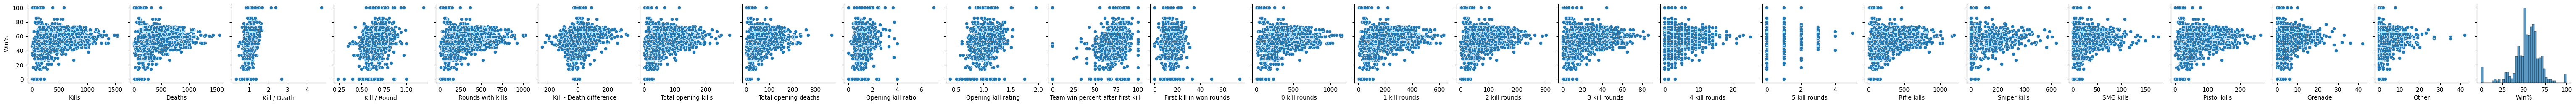

In [35]:
sns.pairplot(stats_win, y_vars="Win%")

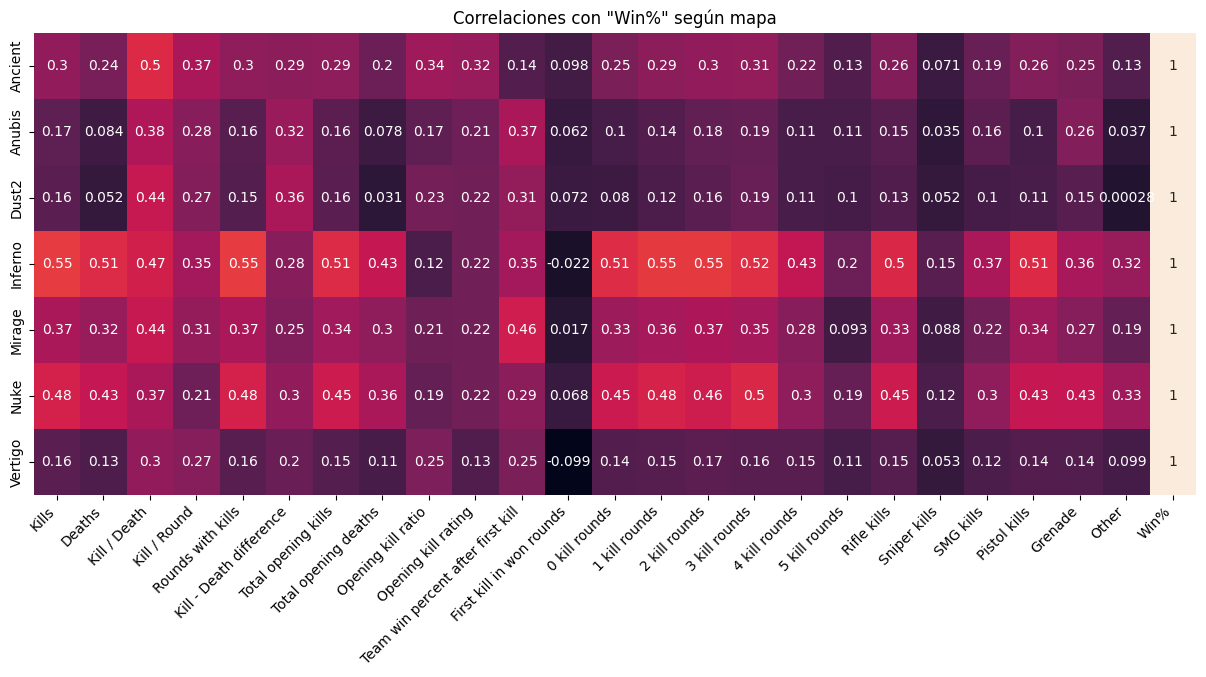

In [36]:
maps = ['Ancient', 'Anubis', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Vertigo']
variables = list(stats_win.columns)
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa')

plt.xticks(rotation=45, ha='right')

plt.show()

Abrá algún cambio si filtramos ``Win percent`` a valores en (0, 100).

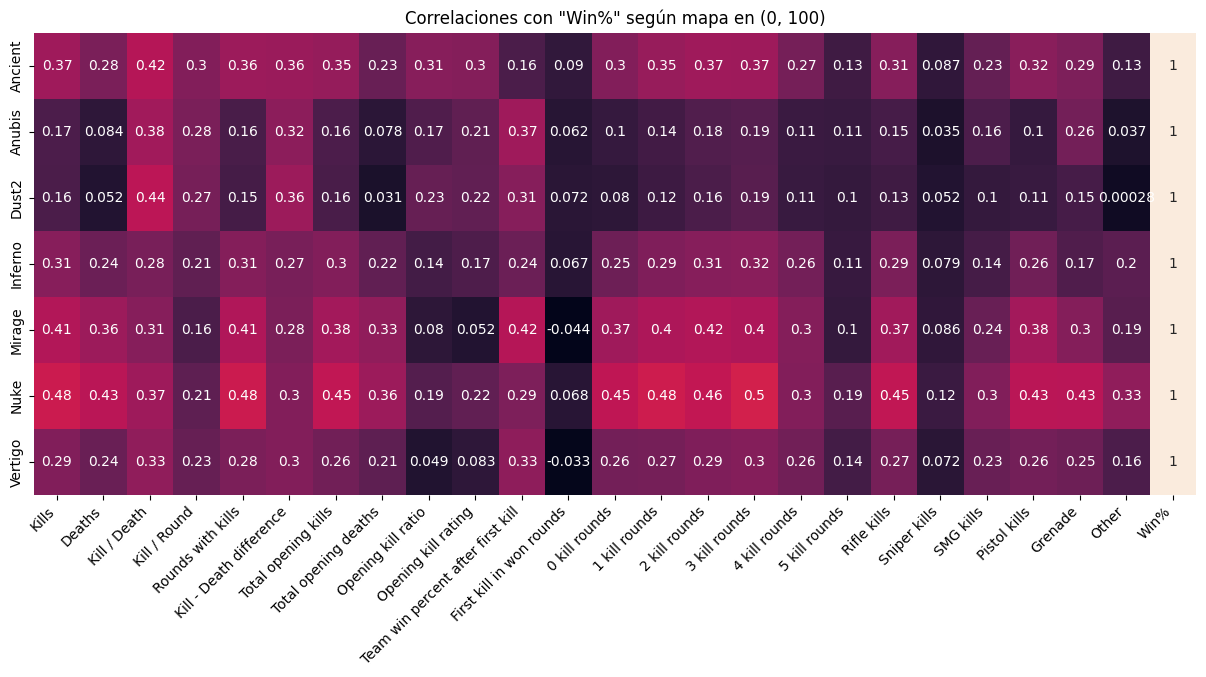

In [37]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Win%"] != 0]
    filtro = filtro[filtro["Win%"] != 100]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en (0, 100)')

plt.xticks(rotation=45, ha='right')

plt.show()

En los equipos, los jugadores tienen asignados diferentes roles. Uno de ellos es el "awper", caracterizado ser el jugador que lleva el arma "AWP" en las rondas. 

Definimos a un awper a aquellos jugadores con más de 150 Sniper kills. Veamos si hay algún cambio en las correlaciones, sobre todo en la variable ``Sniper kills``.

In [38]:
stats_win["Sniper kills"].quantile(.9)

np.float64(174.20000000000027)

<Axes: ylabel='Sniper kills'>

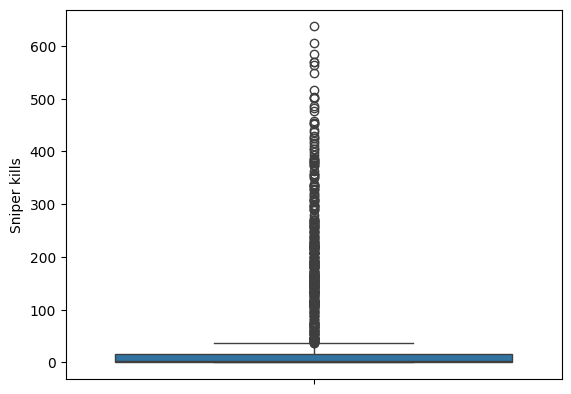

In [39]:
sns.boxplot(stats_win["Sniper kills"])

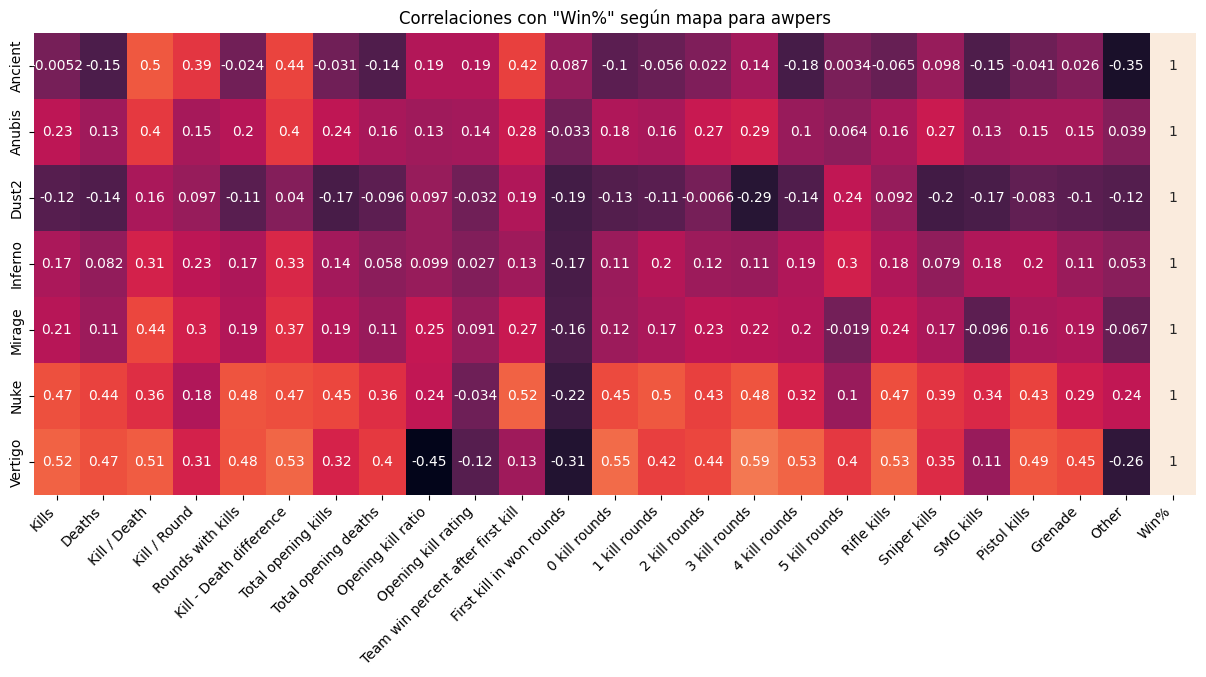

In [40]:
corr = []
for map_name in maps:
    filtro = stats_win[stats_win["Map Name"] == map_name]
    filtro = filtro[filtro["Sniper kills"] >= 150]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa para awpers')

plt.xticks(rotation=45, ha='right')

plt.show()

Vemos que los awpers tiene más impacto en los mapas de Nuke y Vertigo.

## Win% y Team Stats

In [41]:
df_teams.head()

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,Round 2 conv,Round 2 break,Round win%,Opening duel won%,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,94.7,10.0,53.9,53.5,0.81,74.4,30.3,19.9,20.9,0.27
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,96.4,11.1,54.6,54.2,0.87,74.8,30.6,22.9,28.0,0.34
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,90.0,15.4,54.4,51.3,0.86,73.8,34.1,20.4,24.2,0.23
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,87.0,23.8,46.8,45.9,0.79,70.8,26.5,16.9,26.0,0.22
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,91.3,12.5,51.7,46.7,0.80,74.8,31.5,21.0,23.1,0.18


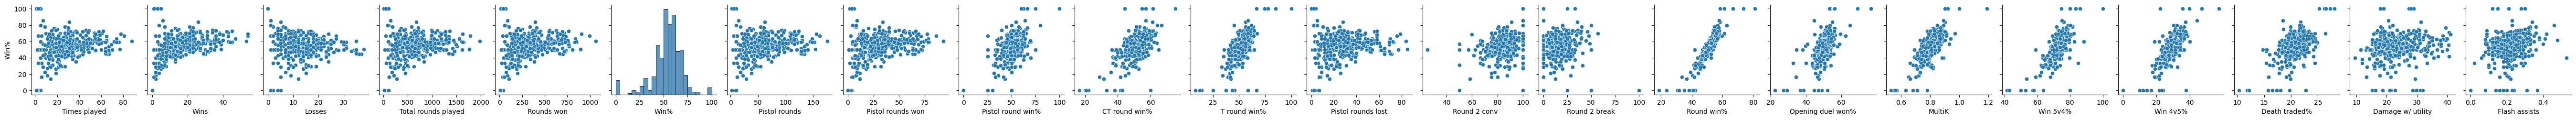

In [42]:
sns.pairplot(df_teams, y_vars="Win%")

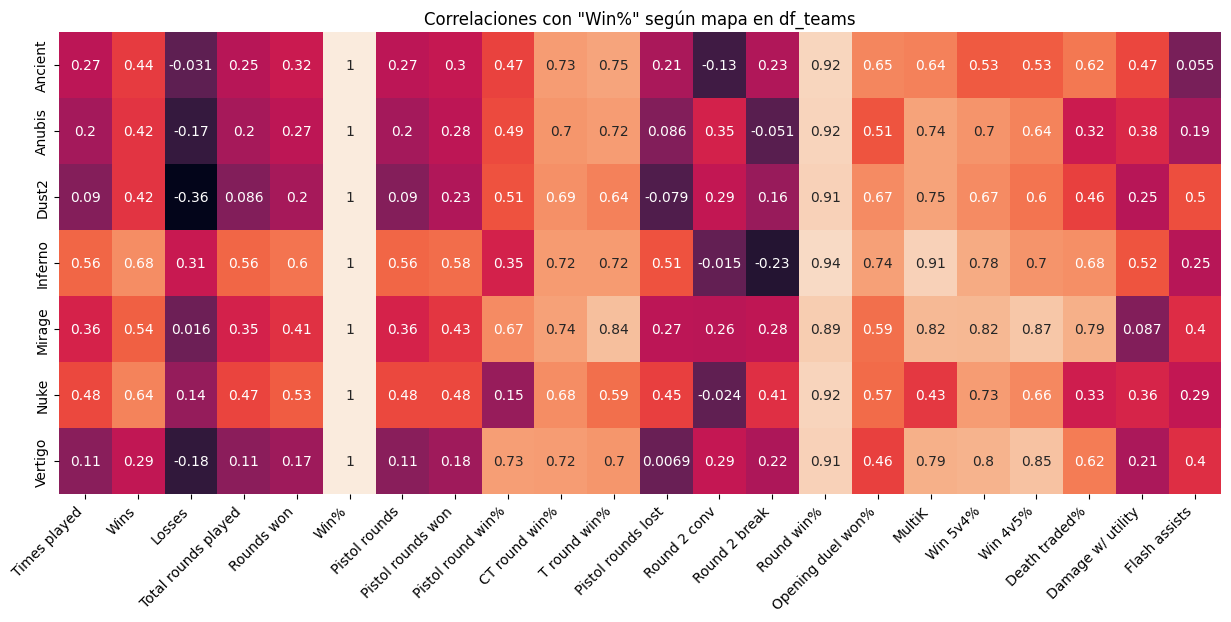

In [43]:
variables = list(df_teams.columns)
variables.remove("Team")
variables.remove("Group")
variables.remove("Map Name")

corr = []
for map_name in maps:
    filtro = df_teams[df_teams["Map Name"] == map_name]
    corr_win = filtro.corr(numeric_only=True)["Win%"]

    corr.append(list(corr_win))

corr_win_df = pd.DataFrame(corr, index = maps)
corr_win_df.columns = variables

corr_win_df

plt.figure(figsize=(15, 6))
sns.heatmap(corr_win_df, annot=True, cbar=False)
plt.title('Correlaciones con "Win%" según mapa en df_teams')

plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Modelos de predicción

## Métricas de equipo

Dadas las observaciones vistas en el EDA, integraremos las stats de los jugadores a DataFrame ``df_teams``, de manera de tener los datos más representativos en de los jugadores de un equipo en todos los mapas.

Vimos que hay ciertas stats que se correlacionan más que otras con el Win% de su equipo. Para integrarlas utilizaremos árboles de decisiones, pero no tan solo uno y arriesgarnos a producir un overfitting o a obtener malos resultados por el ruido, en cambio usaremos varios de ellos utilizando ``RandomForestRegressor`` que finalmente nos dirá cuales stats de los jugadores tienen más peso en el porcentaje de victorias del equipo.

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Separar variables predictoras (X) y variable objetivo (y)
X = stats_win.drop(columns=['Win%', 'Map Name'])
y = stats_win['Win%']

# Normalización con StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Crear modelo Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Validación cruzada con RMSE
scores = cross_val_score(rf_model, X_sc, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

rmse_scores = -scores

print("RMSE por partición:", rmse_scores)
print("Promedio de RMSE:", rmse_scores.mean())
print("Desviación estándar de RMSE:", rmse_scores.std())

RMSE por partición: [ 9.94169634 11.43925049 14.01956798 11.66314944 16.3167762 ]
Promedio de RMSE: 12.676088090287303
Desviación estándar de RMSE: 2.2401900945845363


In [45]:
def comparacion_stats_por_mapa(df: pd.DataFrame, titulo: str) -> pd.DataFrame:
    feature_importance_df = pd.DataFrame()
    for map_name in maps:
        filtro = df[df["Map Name"] == map_name]

        X = filtro.drop(columns=['Win%', 'Map Name'])
        y = filtro['Win%']

        rf_model.fit(X, y)

        # Importancia de características
        feature_importance_map = pd.DataFrame(rf_model.feature_importances_, columns=[map_name], index=X.columns)

        feature_importance_df = pd.concat([feature_importance_df, feature_importance_map], axis=1)

    df_melted = feature_importance_df.T.reset_index().melt(id_vars='index', var_name='Columna', value_name='Valor')
    df_melted.rename(columns={'index': 'Fila'}, inplace=True)
    df_melted

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Columna', y='Valor', hue='Fila', palette='Set1')

    plt.title(titulo, fontsize=16)
    plt.ylabel('Peso')
    plt.xlabel('Stat')
    plt.legend(title='Filas', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return feature_importance_df.T

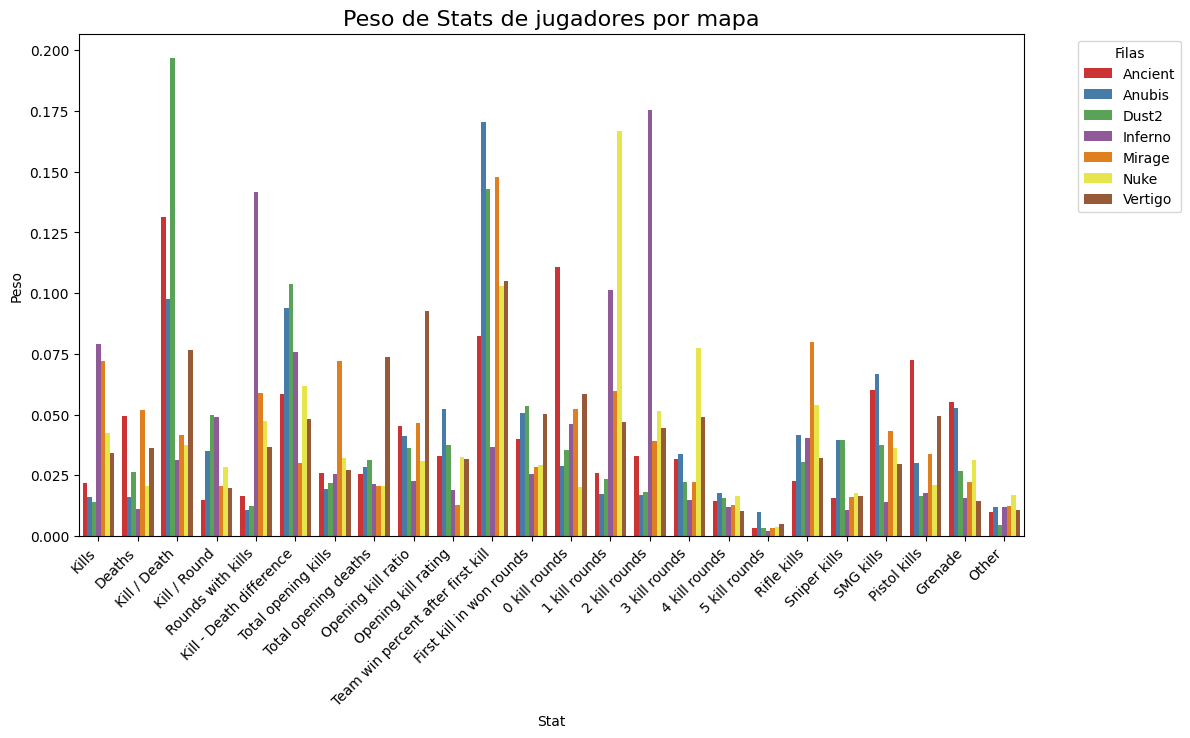

In [46]:
a = comparacion_stats_por_mapa(stats_win, "Peso de Stats de jugadores por mapa")

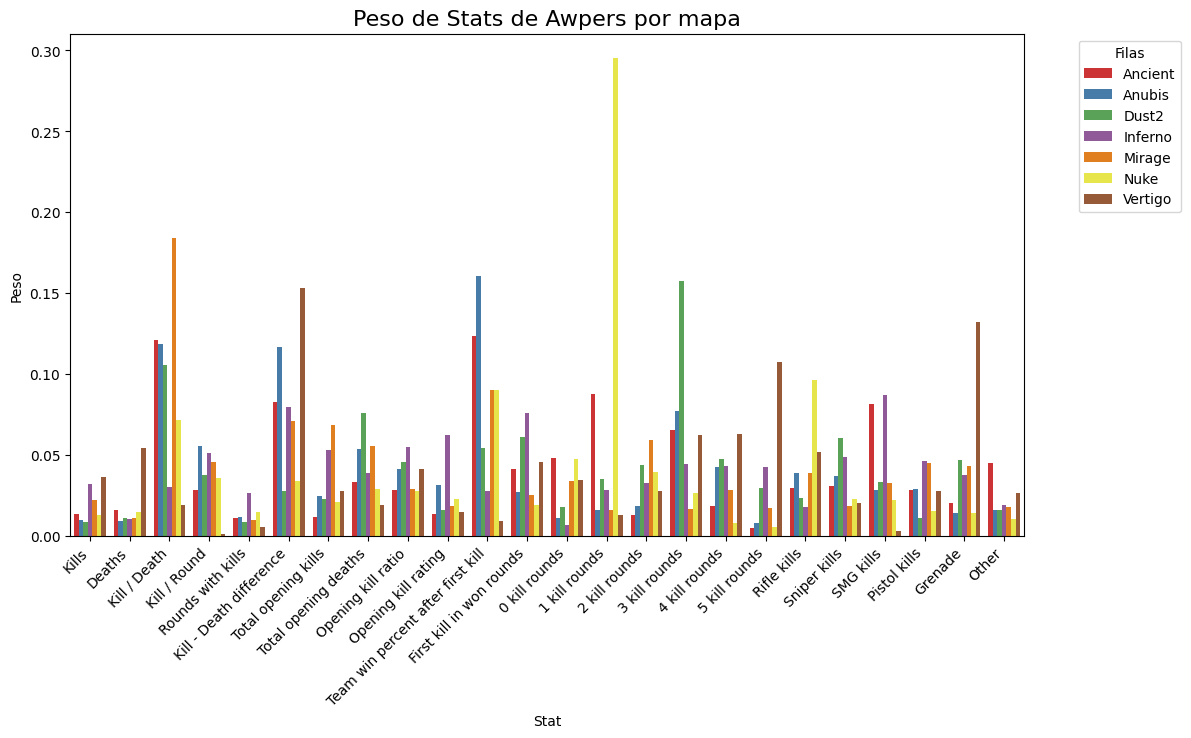

In [47]:
stats_awpers = stats_win[stats_win["Sniper kills"] >= 150]
peso_awpers = comparacion_stats_por_mapa(stats_awpers, "Peso de Stats de Awpers por mapa")

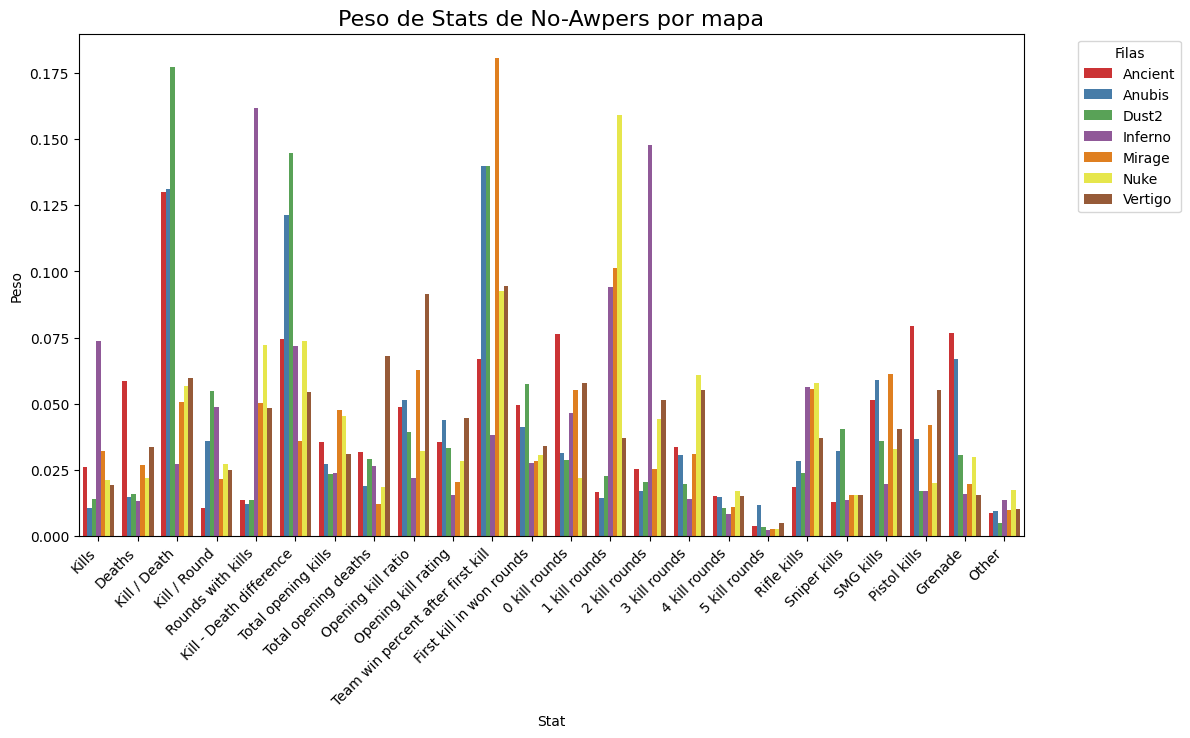

In [48]:
stats_not_awpers = stats_win[stats_win["Sniper kills"] <= 150]
pesos_not_awpers = comparacion_stats_por_mapa(stats_not_awpers, "Peso de Stats de No-Awpers por mapa")

Para integrar los datos de manera a ``df_team`` vamos a estandarizar los datos y luego calcular el valor del jugardor en 4 grupos diferentes, para así promediarlo con el de sus compañeros de equipo. 

In [49]:
df_players

,Kills,Deaths,Kill / Death,Kill / Round,Rounds with kills,Kill - Death difference,Total opening kills,Total opening deaths,Opening kill ratio,Opening kill rating,...,Rifle kills,Sniper kills,SMG kills,Pistol kills,Grenade,Other,Player,Group,Team,Map Name
0,392,473,0.83,0.54,296,-81,72,86,0.84,0.97,...,242,1,79,55,16,5,aleksib,europa_1,Natus Vincere,Ancient
1,509,490,1.04,0.70,338,19,101,108,0.94,1.12,...,401,6,10,86,4,3,im,europa_1,Natus Vincere,Ancient
2,529,450,1.18,0.73,361,79,74,45,1.64,1.07,...,419,2,22,84,3,1,b1t,europa_1,Natus Vincere,Ancient
3,540,454,1.19,0.75,355,86,75,60,1.25,1.05,...,437,5,23,72,3,2,jl,europa_1,Natus Vincere,Ancient
4,505,419,1.21,0.70,344,86,65,37,1.76,1.03,...,234,164,14,92,3,1,w0nderful,europa_1,Natus Vincere,Ancient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,163,190,0.86,0.60,110,-27,21,31,0.68,0.86,...,130,0,3,28,2,2,sener1,asia_rmr,DRILLAS,Vertigo
1900,56,43,1.30,0.77,37,13,9,3,3.00,1.21,...,47,0,1,8,0,0,kvem,asia_rmr,DRILLAS,Vertigo
1901,372,320,1.16,0.76,244,52,66,38,1.74,1.21,...,169,133,16,53,3,0,woro2k,asia_rmr,DRILLAS,Vertigo
1902,94,112,0.84,0.55,68,-18,11,10,1.10,0.89,...,71,1,8,13,1,1,meztal,asia_rmr,DRILLAS,Vertigo


In [50]:
from sklearn.preprocessing import StandardScaler

awpers = df_players[df_players["Sniper kills"] >= 150]
non_awpers = df_players[df_players["Sniper kills"] < 150]

def normalizar_stats(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include=["number"])
    non_numeric_columns = df.select_dtypes(exclude=["number"])

    scaler = StandardScaler()
    numeric_columns_normalized = scaler.fit_transform(numeric_columns)

    stats_normalized = non_numeric_columns.copy()
    stats_normalized[numeric_columns.columns] = numeric_columns_normalized
    return stats_normalized

awpers_normalized     = normalizar_stats(awpers)
non_awpers_normalized = normalizar_stats(non_awpers)

In [51]:
Overall_stats = ['Kills', 'Deaths', 'Kill / Death', 'Kill / Round', 'Rounds with kills', 'Kill - Death difference']
Opening_stats = ['Total opening kills', 'Total opening deaths', 'Opening kill ratio', 'Opening kill rating', 'Team win percent after first kill', 'First kill in won rounds']
Round_stats = ['0 kill rounds', '1 kill rounds', '2 kill rounds', '3 kill rounds', '4 kill rounds', '5 kill rounds']
Weapon_stats = ['Rifle kills', 'Sniper kills', 'SMG kills', 'Pistol kills', 'Grenade', 'Other']

def stats_with_weight(df: pd.DataFrame) -> pd.DataFrame:
    df_final = pd.DataFrame()
    for map_name in maps:
        stats_map = df[df["Map Name"] == map_name].copy()
        weight_map = peso_awpers.loc[map_name]

        stats_map["Overall Stats"] = stats_map[Overall_stats].dot(weight_map[Overall_stats])
        stats_map["Opening Stats"] = stats_map[Opening_stats].dot(weight_map[Opening_stats])
        stats_map["Round Stats"] = stats_map[Round_stats].dot(weight_map[Round_stats])
        stats_map["Weapon Stats"] = stats_map[Weapon_stats].dot(weight_map[Weapon_stats])

        df_final = pd.concat([df_final, stats_map])
    
    return df_final

awpers = stats_with_weight(awpers_normalized)
non_awpers = stats_with_weight(non_awpers_normalized)

In [52]:
a = pd.concat([awpers, non_awpers])
a = a.groupby(["Team", "Map Name"], observed=False)[["Overall Stats", "Opening Stats", "Round Stats", "Weapon Stats"]].mean()

In [53]:
df_teams = df_teams.merge(a.reset_index(), on=['Team', 'Map Name'], how='inner')
df_teams

,Group,Team,Map Name,Times played,Wins,Losses,Total rounds played,Rounds won,Win%,Pistol rounds,...,MultiK,Win 5v4%,Win 4v5%,Death traded%,Damage w/ utility,Flash assists,Overall Stats,Opening Stats,Round Stats,Weapon Stats
0,europa_1,Natus Vincere,Ancient,34,22,12,724,390,64.7,68,...,0.81,74.4,30.3,19.9,20.9,0.27,0.052658,0.026785,0.047933,0.005570
1,europa_1,MOUZ,Ancient,23,14,9,513,280,60.9,46,...,0.87,74.8,30.6,22.9,28.0,0.34,0.068365,0.044518,-0.043669,-0.030177
2,europa_1,FaZe,Ancient,33,21,12,752,409,63.6,66,...,0.86,73.8,34.1,20.4,24.2,0.23,0.097487,0.025902,0.081147,0.066875
3,europa_1,Falcons,Ancient,22,8,14,479,224,36.4,44,...,0.79,70.8,26.5,16.9,26.0,0.22,-0.121819,-0.269245,-0.202882,-0.172128
4,europa_1,BetBoom,Ancient,47,28,19,978,506,59.6,94,...,0.80,74.8,31.5,21.0,23.1,0.18,-0.067713,0.031092,0.163174,0.141482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,asia_rmr,Lynn Vision,Vertigo,7,2,5,150,72,28.6,14,...,0.81,63.2,32.4,20.5,21.8,0.20,-0.166310,-0.080869,-0.287349,-0.233821
366,asia_rmr,Rare Atom,Vertigo,12,7,5,254,134,58.3,24,...,0.85,74.4,31.8,19.2,31.1,0.22,-0.118486,-0.040787,-0.209938,-0.216302
367,asia_rmr,TALON,Vertigo,8,4,4,180,92,50.0,16,...,0.81,69.9,31.0,24.2,28.7,0.24,0.048760,0.043381,-0.033921,-0.061856
368,asia_rmr,GR,Vertigo,1,0,1,21,8,0.0,2,...,0.71,63.6,10.0,12.2,22.8,0.00,-0.194553,-0.056301,-0.330347,-0.266732


In [54]:
from scipy.stats import pearsonr

c1 = pearsonr(df_teams["Overall Stats"], df_teams["Win%"])
c2 = pearsonr(df_teams["Opening Stats"], df_teams["Win%"])
c3 = pearsonr(df_teams["Round Stats"], df_teams["Win%"])
c4 = pearsonr(df_teams["Weapon Stats"], df_teams["Win%"])

print(f"Correlación entre métrica del equipo y victorias: {c1[0]}, {c2[0]}, {c3[0]}, {c4[0]}")

Correlación entre métrica del equipo y victorias: 0.6683528703617229, 0.430730817299308, 0.2694418394889039, 0.3243052420481466


## Prueba de Modelos

Como nuestro objetivo es predecir quien ganará un enfrentamiento entre dos equipos, hay que entrenar un modelo que, al pasarle dos equipos, nos de la probabilidad de que un equipo le gane al otro para cada uno de los 7 mapas.

In [55]:
df_complete = pd.merge(df_matches, df_teams, how="left", left_on=["Team", "Map Name"], right_on=["Team", "Map Name"])
df_complete = pd.merge(df_complete, df_teams, how="left", left_on=["Opponent", "Map Name"], right_on=["Team", "Map Name"])

In [56]:
df_complete = df_complete.drop(["Team_y"], axis=1)
df_complete = df_complete.rename({
    "Opponent": "Team_y"
}, axis=1)


In [57]:
maps_encoded = pd.get_dummies(df_complete['Map Name'], prefix='Map')
df = pd.concat([df_complete, maps_encoded], axis=1)
df = df.drop(columns=['Map Name'])
df

,Date,Team_x,Team_y,Result RW,Result RL,W/L,Result Diff,Group_x,Times played_x,Wins_x,...,Opening Stats_y,Round Stats_y,Weapon Stats_y,Map_Ancient,Map_Anubis,Map_Dust2,Map_Inferno,Map_Mirage,Map_Nuke,Map_Vertigo
0,2024-11-19,Natus Vincere,SAW,13,2,1,11,europa_1,34,22,...,0.014127,0.130381,0.085314,True,False,False,False,False,False,False
1,2024-11-19,Natus Vincere,SAW,13,10,1,3,europa_1,31,16,...,0.115073,0.610395,0.199266,False,False,False,False,False,True,False
2,2024-11-18,Natus Vincere,MOUZ,7,13,0,-6,europa_1,25,14,...,-0.059277,-0.063084,-0.100125,False,False,False,True,False,False,False
3,2024-11-18,Natus Vincere,MOUZ,8,13,0,-5,europa_1,17,13,...,-0.030391,-0.240444,-0.071975,False,False,True,False,False,False,False
4,2024-11-18,Natus Vincere,MOUZ,13,4,1,9,europa_1,38,27,...,0.063843,0.020289,-0.038505,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5861,2024-04-10,DRILLAS,GamerLegion,13,10,1,3,asia_rmr,12,5,...,-0.051669,0.036320,0.016746,False,True,False,False,False,False,False
5862,2024-09-30,DRILLAS,TSM,8,13,0,-5,asia_rmr,5,2,...,-0.011889,0.224830,0.092282,False,False,False,False,False,True,False
5863,2024-09-30,DRILLAS,TSM,11,13,0,-2,asia_rmr,16,9,...,-0.045440,0.145174,0.094452,True,False,False,False,False,False,False
5864,2024-09-24,DRILLAS,Passion UA,16,14,1,2,asia_rmr,13,9,...,0.336853,0.449635,0.463260,False,False,False,False,True,False,False


In [58]:
df = df.drop(columns=["Date", "Team_x", "Team_y", "Result RW", "Result RL", "Group_x", "Group_y"])
df = df.dropna()

In [59]:
team_stats_columns = df.columns[2:24]
team_stats_columns = team_stats_columns.append(df.columns[28:-11])
team_stats_columns

Index(['Times played_x', 'Wins_x', 'Losses_x', 'Total rounds played_x',
       'Rounds won_x', 'Win%_x', 'Pistol rounds_x', 'Pistol rounds won_x',
       'Pistol round win%_x', 'CT round win%_x', 'T round win%_x',
       'Pistol rounds lost_x', 'Round 2 conv_x', 'Round 2 break_x',
       'Round win%_x', 'Opening duel won%_x', 'MultiK_x', 'Win 5v4%_x',
       'Win 4v5%_x', 'Death traded%_x', 'Damage w/ utility_x',
       'Flash assists_x', 'Times played_y', 'Wins_y', 'Losses_y',
       'Total rounds played_y', 'Rounds won_y', 'Win%_y', 'Pistol rounds_y',
       'Pistol rounds won_y', 'Pistol round win%_y', 'CT round win%_y',
       'T round win%_y', 'Pistol rounds lost_y', 'Round 2 conv_y',
       'Round 2 break_y', 'Round win%_y', 'Opening duel won%_y', 'MultiK_y',
       'Win 5v4%_y', 'Win 4v5%_y', 'Death traded%_y', 'Damage w/ utility_y',
       'Flash assists_y'],
      dtype='object')

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[team_stats_columns] = scaler.fit_transform(df[team_stats_columns])

### Regresión Logística

In [61]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.63
ROC AUC: 0.67


Confusion matrix: [[379 207]
 [226 360]]
Accuracy: 0.6305460750853242
Recall: 0.6143344709897611
Precision: 0.6349206349206349
F score: 0.6244579358196011
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       586
           1       0.63      0.61      0.62       586

    accuracy                           0.63      1172
   macro avg       0.63      0.63      0.63      1172
weighted avg       0.63      0.63      0.63      1172



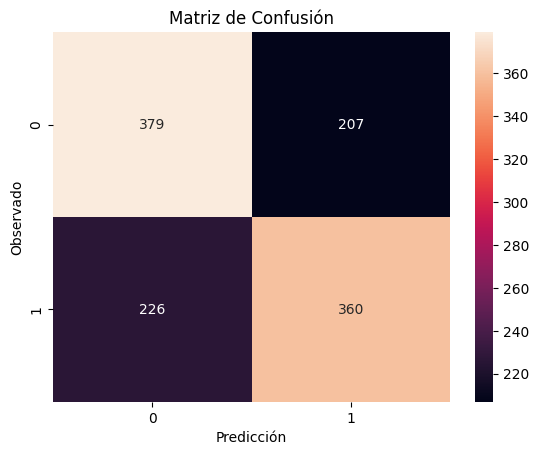

In [63]:
from sklearn import metrics

#matriz de confusión
cm = metrics.confusion_matrix(y_test, y_pred)

print('Confusion matrix:', cm)

#graficamos la matriz de confusión
sns.heatmap(cm, annot=True, fmt="")
plt.ylabel('Observado')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')

accuracy=metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

recall=metrics.recall_score(y_test, y_pred)
print('Recall:', recall)

precision=metrics.precision_score(y_test, y_pred)
print('Precision:', precision)

fscore=metrics.f1_score(y_test, y_pred)
print('F score:', fscore)

#también podemos imprimir un resumen de las métricas de clasificación
report0 = metrics.classification_report(y_test, y_pred)
print(report0)

### Regresión Lineal

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['Result Diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 5.67
R²: 0.09


### Clasificación con PCA y SCV

In [75]:
from sklearn.decomposition import PCA

X = df.drop(columns=['W/L', 'Result Diff'])
y = df['W/L']

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)

principal_Df = pd.DataFrame(
    data = principalComponents,
    # columns = [
    #     'principal component 1',
    #     'principal component 2',
    #     'principal component 3'
    # ]
)

In [76]:
principal_Df

,0,1,2,3,4
0,-0.142823,-0.940972,0.227817,0.300498,-1.737792
1,2.636042,4.679765,-0.586029,2.341934,-1.118617
2,-3.899093,-0.486015,1.701858,-1.629835,0.102726
3,-4.842633,-2.352798,2.166386,1.619815,-1.356870
4,0.378534,-0.250989,2.683001,3.449509,0.320029
...,...,...,...,...,...
5853,-4.206933,2.172770,-2.331225,-1.720189,-0.942204
5854,-3.471569,2.645390,-2.690848,1.449116,-2.725754
5855,-2.313021,1.551037,1.474281,-1.026578,-2.111494
5856,2.273916,1.974863,0.320487,0.661788,-7.842707


In [77]:
from sklearn.svm import SVC

X = principal_Df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# rbf = Gaussian Kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 0.6161922044009523


Confusion matrix: [[358 228]
 [217 369]]
Accuracy: 0.6203071672354948
Recall: 0.6296928327645052
Precision: 0.6180904522613065
F score: 0.6238377007607777
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       586
           1       0.62      0.63      0.62       586

    accuracy                           0.62      1172
   macro avg       0.62      0.62      0.62      1172
weighted avg       0.62      0.62      0.62      1172



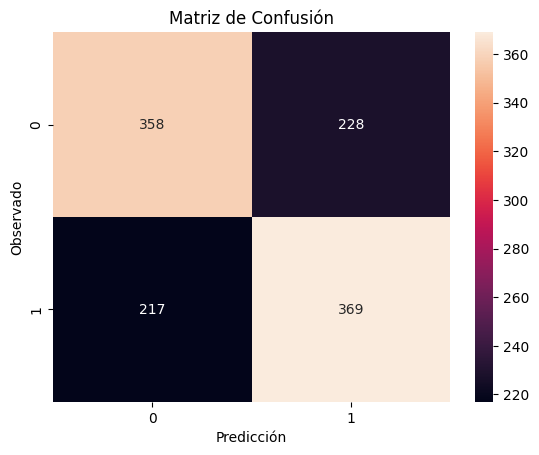

In [78]:
#matriz de confusión
cm = metrics.confusion_matrix(y_test, y_pred)

print('Confusion matrix:', cm)

#graficamos la matriz de confusión
sns.heatmap(cm, annot=True, fmt="")
plt.ylabel('Observado')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')

accuracy=metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

recall=metrics.recall_score(y_test, y_pred)
print('Recall:', recall)

precision=metrics.precision_score(y_test, y_pred)
print('Precision:', precision)

fscore=metrics.f1_score(y_test, y_pred)
print('F score:', fscore)

#también podemos imprimir un resumen de las métricas de clasificación
report0 = metrics.classification_report(y_test, y_pred)
print(report0)

# 4. Ganador del Major

In [79]:
# Utilizar el modelo entrenado para decir quien ganará el Major